In [1]:
import pandas as pd
import os
import glob

print("--- ЗАГРУЗКА ДАННЫХ ---")

# --- Шаг 1: Загружаем наш главный файл с целевой переменной ---
# Убедитесь, что вы используете обновленную версию файла floods_target.csv с данными за 2024 год
try:
    target_df = pd.read_csv('floods_target.csv')
    print("✅ Файл 'floods_target.csv' успешно загружен.")
    print(f"   Размер таблицы: {target_df.shape}")
    print("-" * 50)
except FileNotFoundError:
    print("❌ Ошибка! Файл 'floods_target.csv' не найден. Убедитесь, что он лежит в той же папке, что и ваш ноутбук.")
    target_df = None

# --- Шаг 2: Загружаем все 45 скачанных файлов с погодой ---
if target_df is not None:
    path_to_weather_data = 'data_weather/'
    
    # Имена файлов у вас могут быть другими, но glob найдет все .csv файлы в папке
    all_weather_files = glob.glob(os.path.join(path_to_weather_data, "*.csv"))

    if not all_weather_files:
        print("❌ Ошибка! Папка 'data_weather' пуста или не найдена.")
    else:
        print(f"Найден(о) {len(all_weather_files)} файлов с погодой. Начинаю загрузку...")
        
        df_list = []
        for filename in all_weather_files:
            df = pd.read_csv(filename, index_col=None, header=0)
            # Добавляем колонку с именем файла, чтобы знать, откуда пришли данные
            df['source_file'] = os.path.basename(filename)
            df_list.append(df)

        # Объединяем все маленькие таблицы в одну большую
        weather_df = pd.concat(df_list, axis=0, ignore_index=True)

        print("\n✅ Все файлы с погодой успешно объединены в одну таблицу.")
        print("--- Общая информация по таблице погоды ---")
        print(f"   Итоговый размер таблицы: {weather_df.shape}")
        
        # Проверим, данные из каких городов загрузились
        cities = weather_df['name'].unique()
        print(f"   Данные содержат следующие города: {cities}")
        
        print("\n--- Первые 5 строк таблицы погоды ---")
        print(weather_df.head())
        print("-" * 50)

--- ЗАГРУЗКА ДАННЫХ ---
✅ Файл 'floods_target.csv' успешно загружен.
   Размер таблицы: (136, 3)
--------------------------------------------------
Найден(о) 45 файлов с погодой. Начинаю загрузку...

✅ Все файлы с погодой успешно объединены в одну таблицу.
--- Общая информация по таблице погоды ---
   Итоговый размер таблицы: (7172, 34)
   Данные содержат следующие города: ['Астана, Қазақстан' 'Уральск' 'Уральск, Қазақстан' 'Усть-Каменогорск'
 'Усть-Каменогорск, Қазақстан' 'Усть-каменогорск, Қазақстан']

--- Первые 5 строк таблицы погоды ---
                name    datetime  tempmax  tempmin  temp  feelslikemax  \
0  Астана, Қазақстан  2009-12-01     -0.9     -1.9  -1.3          -3.6   
1  Астана, Қазақстан  2009-12-02     -0.9     -6.9  -3.0          -2.9   
2  Астана, Қазақстан  2009-12-03     -2.1     -8.9  -6.5          -4.9   
3  Астана, Қазақстан  2009-12-04     -1.9    -10.9  -5.7          -8.4   
4  Астана, Қазақстан  2009-12-05     -1.9     -9.9  -3.7          -6.7   

   feel

In [2]:
# --- ЭТАП 2: ОЧИСТКА И ПОДГОТОВКА ДАННЫХ ---

print("--- 2.1. Очистка названий городов ---")
# Мы видим, что названия городов записаны по-разному. 
# Нам нужно привести их к единому стандарту, чтобы мы могли группировать данные.

# Создаем словарь для замены. Все варианты названий мы приведем к одному.
city_name_mapping = {
    'Астана, Қазақстан': 'Астана',
    'Уральск': 'Уральск',
    'Уральск, Қазақстан': 'Уральск',
    'Усть-Каменогорск': 'Усть-Каменогорск',
    'Усть-Каменогорск, Қазақстан': 'Усть-Каменогорск',
    'Усть-каменогорск, Қазақстан': 'Усть-Каменогорск'
}

# Применяем замену к колонке 'name' и создаем новую колонку 'city'
weather_df['city'] = weather_df['name'].map(city_name_mapping)

print(f"Уникальные названия городов ДО очистки: {weather_df['name'].unique()}")
print(f"✅ Уникальные названия городов ПОСЛЕ очистки: {weather_df['city'].unique()}")
print("-" * 50)


print("\n--- 2.2. Приведение типов данных и удаление лишних колонок ---")

# Колонка 'datetime' сейчас является текстом. Превратим ее в специальный тип "дата",
# чтобы можно было легко извлекать год, месяц, день.
weather_df['datetime'] = pd.to_datetime(weather_df['datetime'])
print("✅ Колонка 'datetime' преобразована в формат даты.")

# В таблице много колонок, которые нам не понадобятся для анализа.
# Оставим только самые важные, чтобы не загромождать данные.
columns_to_keep = [
    'city',          # Наш очищенный город
    'datetime',      # Дата
    'temp',          # Средняя температура
    'tempmax',       # Максимальная температура
    'tempmin',       # Минимальная температура
    'feelslike',     # Ощущаемая температура
    'humidity',      # Влажность
    'precip',        # Количество осадков
    'snow',          # Количество снега
    'snowdepth',     # Глубина снежного покрова
    'windspeed',     # Скорость ветра
    'cloudcover',    # Облачность
]

# Создаем новый DataFrame только с нужными колонками
weather_df_cleaned = weather_df[columns_to_keep].copy()

print(f"✅ Таблица с погодой очищена. Оставили {len(columns_to_keep)} самых важных колонок.")
print(f"   Новый размер таблицы: {weather_df_cleaned.shape}")
print("\n--- Первые 5 строк очищенной таблицы погоды ---")
print(weather_df_cleaned.head())
print("-" * 50)


print("\n--- 2.3. Создание словаря для связи городов и регионов ---")
# В одной таблице у нас города (Астана), а в другой - регионы (Акмолинская область).
# Нам нужен "мостик" между ними, чтобы в будущем их объединить.
region_mapping = {
    'Астана': 'Акмолинская область',
    'Уральск': 'Западно-Казахстанская область',
    'Усть-Каменогорск': 'Восточно-Казахстанская область'
}
# Просто создаем словарь и выводим его на экран, чтобы убедиться, что он есть
print("✅ Словарь для связи 'Город -> Область' создан.")
print(region_mapping)

--- 2.1. Очистка названий городов ---
Уникальные названия городов ДО очистки: ['Астана, Қазақстан' 'Уральск' 'Уральск, Қазақстан' 'Усть-Каменогорск'
 'Усть-Каменогорск, Қазақстан' 'Усть-каменогорск, Қазақстан']
✅ Уникальные названия городов ПОСЛЕ очистки: ['Астана' 'Уральск' 'Усть-Каменогорск']
--------------------------------------------------

--- 2.2. Приведение типов данных и удаление лишних колонок ---
✅ Колонка 'datetime' преобразована в формат даты.
✅ Таблица с погодой очищена. Оставили 12 самых важных колонок.
   Новый размер таблицы: (7172, 12)

--- Первые 5 строк очищенной таблицы погоды ---
     city   datetime  temp  tempmax  tempmin  feelslike  humidity  precip  \
0  Астана 2009-12-01  -1.3     -0.9     -1.9       -6.2      99.1     0.0   
1  Астана 2009-12-02  -3.0     -0.9     -6.9       -6.9      95.3     0.0   
2  Астана 2009-12-03  -6.5     -2.1     -8.9      -11.5      92.7     0.0   
3  Астана 2009-12-04  -5.7     -1.9    -10.9      -12.7      92.8     0.0   
4  Аст

In [3]:
# --- ЭТАП 3: FEATURE ENGINEERING (СОЗДАНИЕ ПРИЗНАКОВ) ---
print("--- 3.1. Определение 'паводкового года' для каждой записи ---")

# Для предсказания паводка 2010 года нам нужны данные с декабря 2009 по апрель 2010.
# Создадим колонку 'prediction_year', чтобы правильно группировать сезоны.
def get_prediction_year(row):
    # Если месяц - декабрь, то он относится к паводковому сезону следующего года
    if row['datetime'].month == 12:
        return row['datetime'].year + 1
    else:
        return row['datetime'].year

weather_df_cleaned['prediction_year'] = weather_df_cleaned.apply(get_prediction_year, axis=1)
print("✅ Колонка 'prediction_year' успешно создана.")
# Посмотрим на результат для нескольких дат
print(weather_df_cleaned[['datetime', 'prediction_year']].head(3))
print(weather_df_cleaned[['datetime', 'prediction_year']].tail(3))
print("-" * 50)


print("\n--- 3.2. Агрегация ежедневных данных в сезонные признаки ---")
# Теперь сгруппируем данные по городу и паводковому году, 
# и для каждой группы посчитаем статистики, которые и будут нашими признаками.
aggregations = {
    'temp': ['mean', 'min', 'max'],           # Средняя, мин и макс температура за сезон
    'precip': ['sum', 'max'],                 # Сумма и макс дневное кол-во осадков
    'snow': ['sum'],                          # Суммарное кол-во снега
    'snowdepth': ['max'],                     # Макс. глубина снега за сезон
    'windspeed': ['mean'],                    # Средняя скорость ветра
    'humidity': ['mean']                      # Средняя влажность
}

# Выполняем группировку и агрегацию
seasonal_features_df = weather_df_cleaned.groupby(['city', 'prediction_year']).agg(aggregations).reset_index()

# После агрегации у колонок появляются двухуровневые имена (например, ('temp', 'mean')). 
# "Сплющим" их в одну строку (например, 'temp_mean').
seasonal_features_df.columns = ['_'.join(col).strip() for col in seasonal_features_df.columns.values]

# Переименуем колонки для удобства
seasonal_features_df = seasonal_features_df.rename(columns={
    'city_': 'city',
    'prediction_year_': 'year',
    'temp_mean': 'season_avg_temp',
    'precip_sum': 'season_total_precip',
    'snow_sum': 'season_total_snow',
    'snowdepth_max': 'season_max_snowdepth',
    # и так далее...
})

print("✅ Сезонные признаки успешно созданы.")
print(f"   Размер таблицы признаков: {seasonal_features_df.shape}")
print("\n--- Первые 5 строк таблицы с сезонными признаками ---")
print(seasonal_features_df.head())
print("-" * 50)


print("\n--- 3.3. Создание финальной таблицы для обучения ---")
# Теперь нам нужно соединить таблицу с признаками (seasonal_features_df)
# и таблицу с целевой переменной (target_df).

# Сначала добавим в таблицу с признаками колонку 'region', используя наш словарь-мостик
seasonal_features_df['region'] = seasonal_features_df['city'].map(region_mapping)

# Объединяем две таблицы по колонкам 'year' и 'region'
# Мы используем 'inner' соединение, чтобы оставить только те регионы, 
# для которых у нас есть данные о погоде (Астана, Уральск, Усть-Каменогорск).
final_df = pd.merge(
    target_df, 
    seasonal_features_df,
    on=['year', 'region'],
    how='inner'
)

print(f"✅ Финальная таблица для обучения модели создана!")
print(f"   Размер итоговой таблицы: {final_df.shape}")
print("\n--- Первые 5 строк финальной таблицы ---")
# Проверим, что для 2017 года в Акмолинской области (Астана) `flood_happened` = 1
print(final_df[final_df['year'] == 2017])

# Сохраним готовую таблицу в CSV-файл, чтобы потом ее можно было легко загрузить
final_df.to_csv('final_data_for_training.csv', index=False)
print("\n✅ Финальная таблица сохранена в файл 'final_data_for_training.csv'")

--- 3.1. Определение 'паводкового года' для каждой записи ---
✅ Колонка 'prediction_year' успешно создана.
    datetime  prediction_year
0 2009-12-01             2010
1 2009-12-02             2010
2 2009-12-03             2010
       datetime  prediction_year
7169 2024-04-28             2024
7170 2024-04-29             2024
7171 2024-04-30             2024
--------------------------------------------------

--- 3.2. Агрегация ежедневных данных в сезонные признаки ---
✅ Сезонные признаки успешно созданы.
   Размер таблицы признаков: (45, 11)

--- Первые 5 строк таблицы с сезонными признаками ---
     city  year  season_avg_temp  temp_min  temp_max  season_total_precip  \
0  Астана  2010       -12.211921     -35.3      17.6                  0.7   
1  Астана  2011       -10.443046     -30.1      17.7                  0.3   
2  Астана  2012       -11.471711     -36.5      19.3                 57.3   
3  Астана  2013        -9.254305     -39.6      16.5                149.5   
4  Астана  20

--- 4.1. Подготовка данных для обучения ---
✅ Данные разделены на обучающую (36 строк) и тестовую (9 строк) выборки.
   Признаки, которые мы используем для обучения: ['season_avg_temp', 'temp_min', 'temp_max', 'season_total_precip', 'precip_max', 'season_total_snow', 'season_max_snowdepth', 'windspeed_mean', 'humidity_mean']
--------------------------------------------------

--- 4.2. Обучение модели (Логистическая регрессия) ---
✅ Модель успешно обучена!
--------------------------------------------------
✅ Модель Логистической регрессии сохранена в файл 'logreg_flood_model.joblib'
--------------------------------------------------

--- 4.3. Оценка качества модели ---
Отчет по качеству модели:
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.33      1.00      0.50         1

    accuracy                           0.78         9
   macro avg       0.67      0.88      0.68         9
weighted avg       0.93  

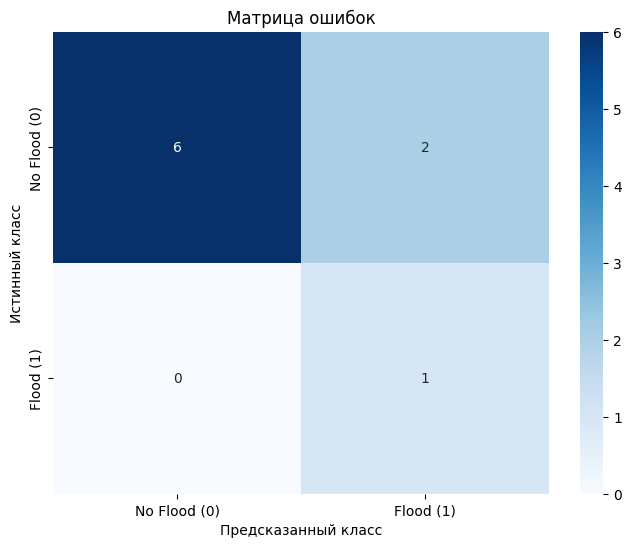

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --- ЭТАП 4: ПОСТРОЕНИЕ И ОБУЧЕНИЕ МОДЕЛИ ---

print("--- 4.1. Подготовка данных для обучения ---")

# Загружаем наш готовый датасет (на случай, если мы перезапускали ноутбук)
df = pd.read_csv('final_data_for_training.csv')

# Определяем признаки (X) и целевую переменную (y)
# X - это все колонки, кроме 'year', 'region', 'city' (они не являются признаками погоды) 
# и 'flood_happened' (это то, что мы предсказываем)
features = [col for col in df.columns if col not in ['year', 'region', 'city', 'flood_happened']]
X = df[features]
y = df['flood_happened']

# Разделяем данные на обучающую и тестовую выборки.
# 80% данных пойдут на обучение, 20% - на тест.
# stratify=y гарантирует, что и в обучении, и в тесте будет одинаковая пропорция паводков и не-паводков.
# random_state=42 делает разделение воспроизводимым.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"✅ Данные разделены на обучающую ({len(X_train)} строк) и тестовую ({len(X_test)} строк) выборки.")
print(f"   Признаки, которые мы используем для обучения: {features}")
print("-" * 50)


print("\n--- 4.2. Обучение модели (Логистическая регрессия) ---")
# Создаем экземпляр модели
# class_weight='balanced' помогает модели лучше работать с несбалансированными данными 
# (у нас паводков меньше, чем не-паводков)
model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)

# Обучаем модель на обучающих данных
model.fit(X_train, y_train)

print("✅ Модель успешно обучена!")
print("-" * 50)

# --- Сохранение модели в файл ---
import joblib
joblib.dump(model, 'logreg_flood_model.joblib')
print("✅ Модель Логистической регрессии сохранена в файл 'logreg_flood_model.joblib'")
print("-" * 50)

print("\n--- 4.3. Оценка качества модели ---")
# Делаем предсказания на тестовых данных, которые модель еще не видела
y_pred = model.predict(X_test)

# Выводим отчет о качестве модели
# Precision - точность (из всех предсказанных паводков, сколько реальных?)
# Recall - полнота (из всех реальных паводков, сколько мы нашли?)
# F1-score - среднее гармоническое между точностью и полнотой
print("Отчет по качеству модели:")
print(classification_report(y_test, y_pred))

# Строим матрицу ошибок (confusion matrix)
# Она показывает, сколько раз модель ошиблась и как именно.
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Flood (0)', 'Flood (1)'], 
            yticklabels=['No Flood (0)', 'Flood (1)'])
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.title('Матрица ошибок')
plt.show()

--- Обучение модели XGBoost ---
✅ Модель XGBoost успешно обучена!

Отчет по качеству модели XGBoost:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       0.00      0.00      0.00         1

    accuracy                           0.89         9
   macro avg       0.44      0.50      0.47         9
weighted avg       0.79      0.89      0.84         9



D:\DataS\рабочий стол\Linkedin обучение\AI engineering\HW number2\kazakhstan-flood-prediction\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:55:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
D:\DataS\рабочий стол\Linkedin обучение\AI engineering\HW number2\kazakhstan-flood-prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
D:\DataS\рабочий стол\Linkedin обучение\AI engineering\HW number2\kazakhstan-flood-prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `z

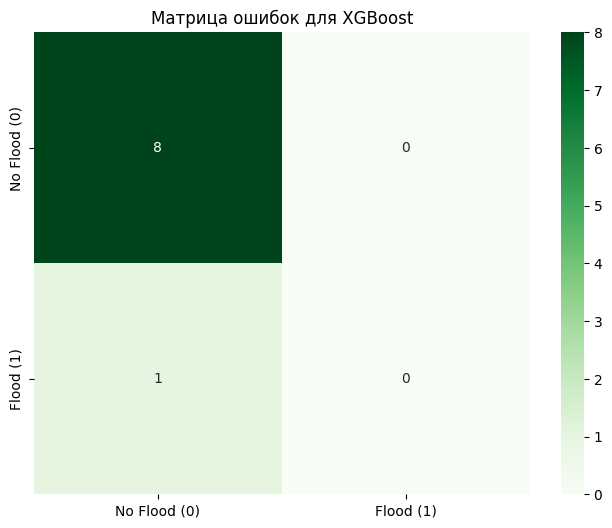


✅ Модель XGBoost СОХРАНЕНА в файл 'flood_prediction_model.joblib'
--------------------------------------------------


In [5]:
import xgboost as xgb
import joblib
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --- ЭТАП 4.5: ОБУЧЕНИЕ ПРОДВИНУТОЙ МОДЕЛИ (XGBoost) И СОХРАНЕНИЕ ---
# Данные (X_train, y_train и т.д.) у нас уже есть из предыдущей ячейки.

print("--- Обучение модели XGBoost ---")
# Рассчитываем веса для балансировки классов
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic', 
    eval_metric='logloss',
    use_label_encoder=False, 
    scale_pos_weight=scale_pos_weight,
    random_state=42
)
# Обучаем модель XGBoost
xgb_model.fit(X_train, y_train)
print("✅ Модель XGBoost успешно обучена!")

# --- Оценка качества XGBoost ---
y_pred_xgb = xgb_model.predict(X_test)
print("\nОтчет по качеству модели XGBoost:")
print(classification_report(y_test, y_pred_xgb))
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt='d', cmap='Greens', xticklabels=['No Flood (0)', 'Flood (1)'], yticklabels=['No Flood (0)', 'Flood (1)'])
plt.title('Матрица ошибок для XGBoost')
plt.show()

# --- ВАЖНЕЙШИЙ ШАГ: СОХРАНЕНИЕ ИМЕННО XGBoost МОДЕЛИ ---
model_filename = 'flood_prediction_model.joblib'
joblib.dump(xgb_model, model_filename) # Мы сохраняем переменную xgb_model, а не старую 'model'
print(f"\n✅ Модель XGBoost СОХРАНЕНА в файл '{model_filename}'")
print("-" * 50)

D:\DataS\рабочий стол\Linkedin обучение\AI engineering\HW number2\kazakhstan-flood-prediction\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


--- 5.1. Загрузка модели и подготовка данных для интерпретации ---
✅ Модель и данные загружены.

--- 5.2. Создание 'объяснятора' (Explainer) ---
✅ SHAP Explainer создан.
--------------------------------------------------

--- 5.3. Глобальная интерпретация: какие признаки самые важные? ---
График важности признаков (в среднем по всем данным):


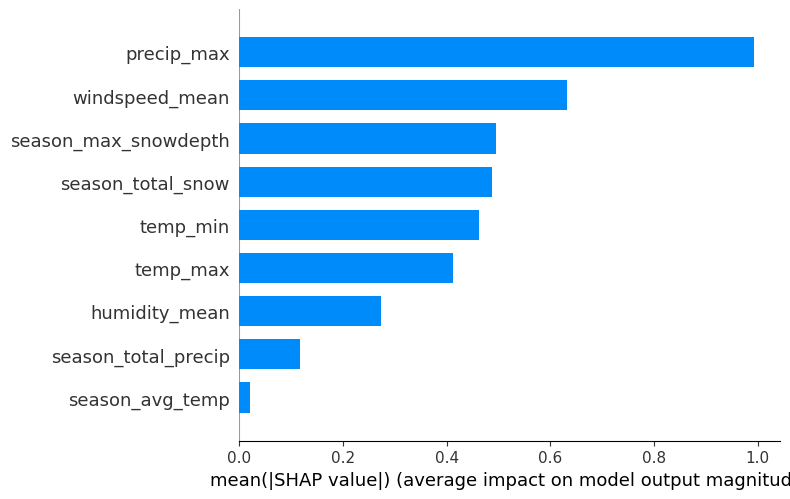


Более детальный график важности признаков (summary_plot):


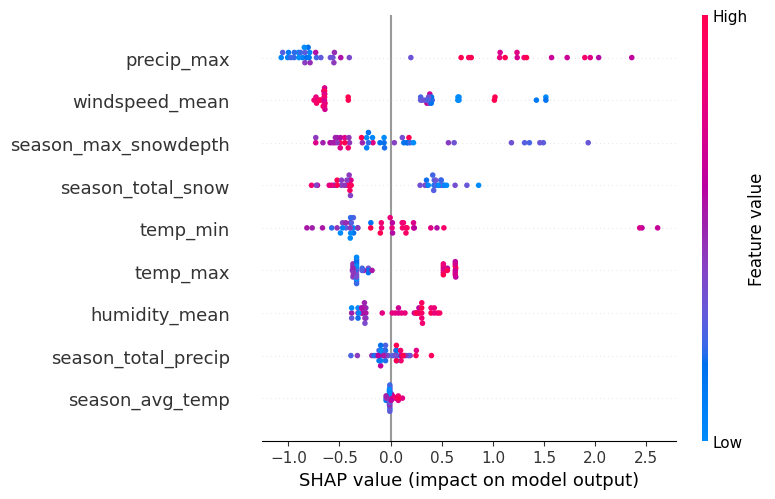


--- 5.4. Локальная интерпретация: почему был сделан конкретный прогноз? ---
Объясняем прогноз для случая:
    year               region  flood_happened    city  season_avg_temp  \
21  2017  Акмолинская область               1  Астана        -7.745033   

    temp_min  temp_max  season_total_precip  precip_max  season_total_snow  \
21     -29.0      18.7                130.3        13.0              315.4   

    season_max_snowdepth  windspeed_mean  humidity_mean  
21                  39.0       30.254305      77.497351  


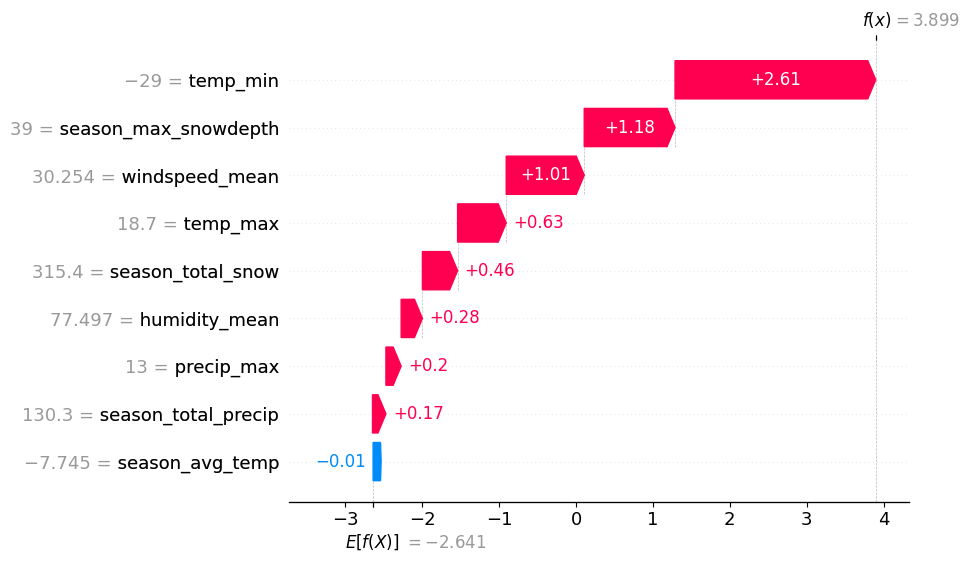

In [6]:
import shap
import pandas as pd
import joblib

# --- ЭТАП 5: ИНТЕРПРЕТАЦИЯ МОДЕЛИ С ПОМОЩЬЮ SHAP ---

print("--- 5.1. Загрузка модели и подготовка данных для интерпретации ---")

# Загружаем нашу лучшую модель
model_filename = 'flood_prediction_model.joblib'
model = joblib.load(model_filename)

# Загружаем данные, на которых обучалась модель
# (SHAP'у нужны данные для построения объяснений)
df = pd.read_csv('final_data_for_training.csv')
features = [col for col in df.columns if col not in ['year', 'region', 'city', 'flood_happened']]
X = df[features]
y = df['flood_happened']
print("✅ Модель и данные загружены.")


print("\n--- 5.2. Создание 'объяснятора' (Explainer) ---")
# SHAP использует разные эксплейнеры для разных моделей. 
# Для XGBoost, LightGBM, CatBoost и деревьев решений подходит TreeExplainer.
explainer = shap.TreeExplainer(model, X) # Передаем модель и фоновые данные
print("✅ SHAP Explainer создан.")
print("-" * 50)


print("\n--- 5.3. Глобальная интерпретация: какие признаки самые важные? ---")
# Рассчитываем SHAP values для всех данных
shap_values = explainer(X)

print("График важности признаков (в среднем по всем данным):")
# Этот график показывает, какие признаки вносят наибольший вклад в предсказания в целом.
shap.summary_plot(shap_values, X, plot_type="bar")
plt.show()

print("\nБолее детальный график важности признаков (summary_plot):")
# Этот график не только показывает важность, но и то, как значения признаков
# (высокие - красный, низкие - синий) влияют на прогноз.
shap.summary_plot(shap_values, X)
plt.show()

print("\n--- 5.4. Локальная интерпретация: почему был сделан конкретный прогноз? ---")
# Давайте объясним прогноз для конкретного случая из наших данных.
# Возьмем, к примеру, 2017 год в Акмолинской области, где был паводок.
instance_to_explain = df[(df['year'] == 2017) & (df['region'] == 'Акмолинская область')]
instance_X = instance_to_explain[features]

print(f"Объясняем прогноз для случая:\n{instance_to_explain}")

# Инициализируем JavaScript для красивых графиков в ноутбуке
shap.initjs()

# Строим waterfall_plot - он наглядно показывает вклад каждого признака в итоговый прогноз
shap.plots.waterfall(shap_values[instance_X.index[0]])